# Predicting Cirrhosis

## Imports and Custom Functions

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.inspection import permutation_importance

# Setting options
from sklearn import set_config
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)

set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [4]:
# Categorical V Target EDA Function
def plot_categorical_vs_target(df, x, y,figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna 
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x]) 
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  
    # Barplot 
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)
  
  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax, 
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax



In [5]:
# Numeric v Target EDA Function
def plot_numeric_vs_target(df, x, y, figsize=(6,4)):
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax



## Load and Clean the Data

In [6]:
# Load in Data
df = pd.read_csv('Data/cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [8]:
df.isna().sum().sum()

1033

In [9]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

106 patients dropped off before follow-up. They represent most of the missing values. So, I am dropping those rows.

In [10]:
# Drop the rows with missing values
df_new = df.dropna()

In [11]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 311
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             276 non-null    int64  
 1   N_Days         276 non-null    int64  
 2   Status         276 non-null    object 
 3   Drug           276 non-null    object 
 4   Age            276 non-null    int64  
 5   Sex            276 non-null    object 
 6   Ascites        276 non-null    object 
 7   Hepatomegaly   276 non-null    object 
 8   Spiders        276 non-null    object 
 9   Edema          276 non-null    object 
 10  Bilirubin      276 non-null    float64
 11  Cholesterol    276 non-null    float64
 12  Albumin        276 non-null    float64
 13  Copper         276 non-null    float64
 14  Alk_Phos       276 non-null    float64
 15  SGOT           276 non-null    float64
 16  Tryglicerides  276 non-null    float64
 17  Platelets      276 non-null    float64
 18  Prothrombi

In [12]:
df_new.isna().sum().sum()

0

In [13]:
df_new.duplicated().sum()

0

In [14]:
df_new.describe()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,158.615942,1979.166667,18189.326087,3.333696,371.260870,3.516812,100.768116,1996.611594,124.119239,124.978261,261.771739,10.735507,3.039855
std,91.662926,1112.380295,3843.555619,4.601074,234.788363,0.404789,88.268746,2115.477894,56.719952,65.280761,93.128857,1.008315,0.853999
min,1.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,28.380000,33.000000,62.000000,9.000000,1.000000
25%,79.750000,1185.750000,15162.500000,0.800000,249.500000,3.310000,42.750000,922.500000,82.457500,85.000000,200.000000,10.000000,2.000000
50%,157.500000,1788.000000,18156.500000,1.400000,310.000000,3.545000,74.000000,1277.500000,116.625000,108.000000,257.000000,10.600000,3.000000
75%,240.250000,2689.750000,20667.500000,3.525000,401.000000,3.772500,129.250000,2068.250000,153.450000,151.250000,318.250000,11.200000,4.000000
max,312.000000,4556.000000,28650.000000,28.000000,1775.000000,4.400000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000


## Exploratory Visualizations

In [15]:
corr = df_new.corr(numeric_only = True)

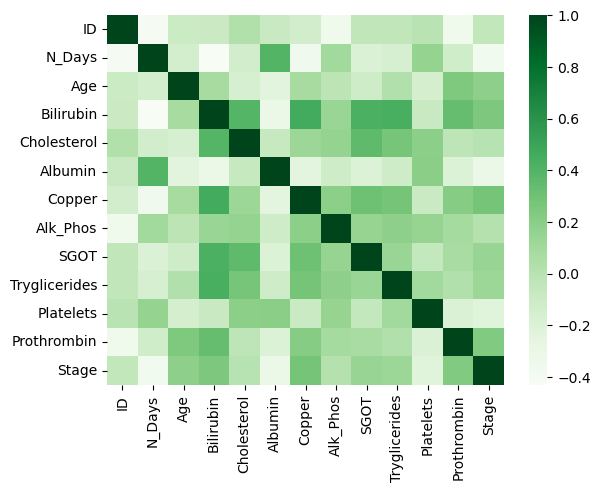

In [16]:
#Create Heatmap to show correlation between numeric features
ax = sns.heatmap(corr, cmap = "Greens")

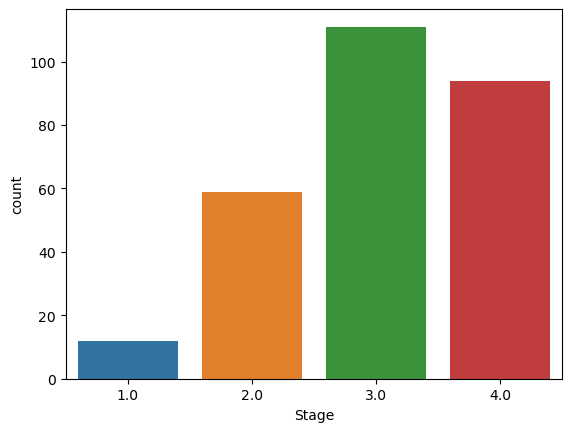

In [17]:
# Create Barplot to show the number of patients in each stage of cirrhosis
ax = sns.countplot(data=df_new, x = "Stage")

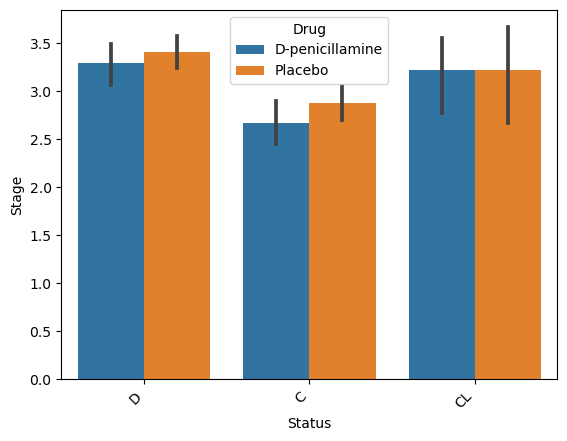

In [18]:
# Create a Grouped Bar Plot of stage and status of patient and whether they were on the drug or a placebo
ax = sns.barplot(data=df_new, x="Status", y="Stage", hue="Drug")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

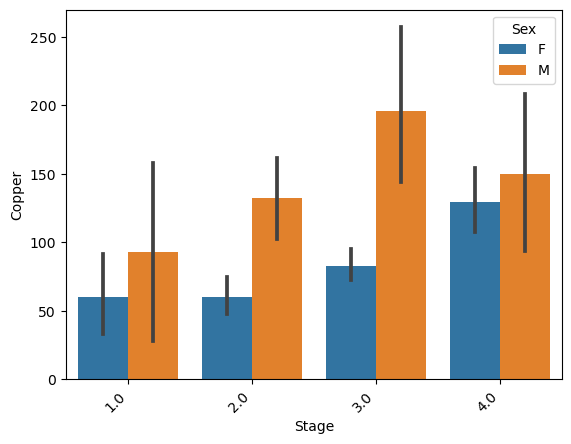

In [19]:
# Create a Grouped Bar Plot of stage, copper levels, and sex
ax = sns.barplot(data=df_new, x="Stage", y="Copper", hue="Sex")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

## Preprocess Data

In [20]:
# Define target
target_col = 'Status'

# Make list of columns to drop. In this case just the id column for now
df_new = df_new.drop(columns = "ID")

# Define X and y
y = df_new[target_col]
X = df_new.drop(columns=[target_col])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



### Create Pipeline

In [21]:
#Create categorical pipeline: Create list, OneHotEncoder, and tuple

#Variable of categorical columns
cat_cols = X_train.select_dtypes('object').columns

#Transformers
ohe = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

#Pipeline
cat_pipeline = make_pipeline(ohe)

#Tuple
ohe_tuple = ('categorical', cat_pipeline, cat_cols)

In [22]:
#Create numerical pipeline: Create list, StandardSclaer and tuple

#Create numerical columns variable
num_cols = X_train.select_dtypes('number').columns

#Transformers
scaler = StandardScaler()

#Pipeline
num_pipeline = make_pipeline(scaler)

#Tuple
num_tuple = ('numeric', num_pipeline, num_cols)

In [23]:
#Build preprocessor with ColumnTransformer
preprocessor = ColumnTransformer([  ohe_tuple,
                                    num_tuple],
                                    verbose_feature_names_out=False)

preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object'))],
                  verbose_feature_names_out=False)

## Run Model and Evaluate

### Random Forest

In [24]:
#Instantiate Random Forest Classifier

random_forest = RandomForestClassifier(random_state=42)

In [25]:
#Build RF Pipeline
rf_pipe = make_pipeline(preprocessor, random_forest)

In [26]:
#Fit on the training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       108
          CL       1.00      1.00      1.00        18
           D       1.00      1.00      1.00        81

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207



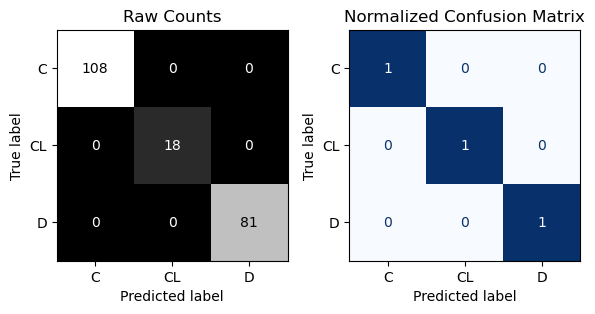


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.81      0.90      0.85        39
           D       0.85      0.73      0.79        30

    accuracy                           0.83        69
   macro avg       0.83      0.82      0.82        69
weighted avg       0.83      0.83      0.82        69



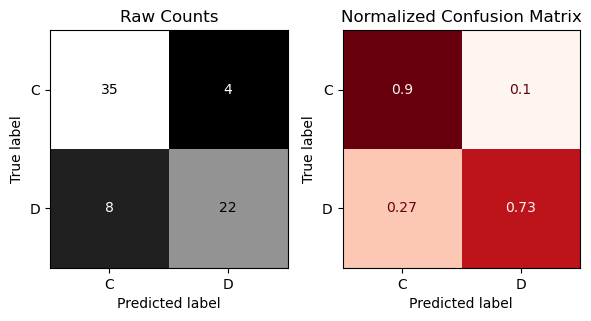

In [27]:
## Evaluate Model
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

### KNN

In [28]:
#Instantiate KNN Classifier

KNN_classifier = KNeighborsClassifier()

In [29]:
#Build KNN Pipeline
KNN_pipe = make_pipeline(preprocessor, KNN_classifier)

In [30]:
#Fit on the training data
KNN_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.71      0.90      0.79       108
          CL       0.75      0.17      0.27        18
           D       0.79      0.64      0.71        81

    accuracy                           0.73       207
   macro avg       0.75      0.57      0.59       207
weighted avg       0.74      0.73      0.71       207



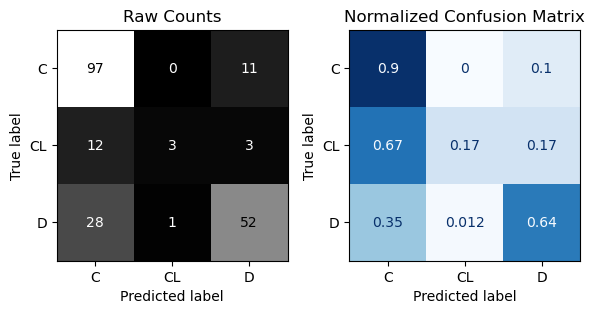


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.82      0.95      0.88        39
          CL       0.00      0.00      0.00         0
           D       0.90      0.63      0.75        30

    accuracy                           0.81        69
   macro avg       0.58      0.53      0.54        69
weighted avg       0.86      0.81      0.82        69



C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


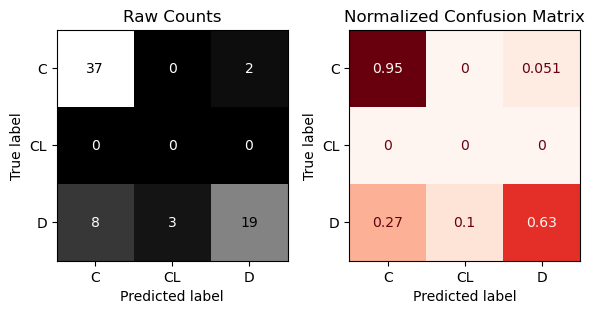

C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\Anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
## Evaluate Model
evaluate_classification(KNN_pipe, X_train, y_train, X_test, y_test)

To further refine the model, I would work with the random forest model moving forward.

## Extract Top 10 Features

In [32]:
r = permutation_importance(rf_pipe, X_test, y_test, n_repeats =5, random_state = 42)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [33]:
## Make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances



N_Days           0.028986
Bilirubin        0.023188
Prothrombin      0.014493
SGOT             0.008696
Alk_Phos         0.005797
Spiders          0.005797
Copper           0.005797
Drug             0.000000
Tryglicerides    0.000000
Stage            0.000000
Edema            0.000000
Ascites          0.000000
Hepatomegaly    -0.002899
Platelets       -0.002899
Sex             -0.005797
Albumin         -0.011594
Age             -0.011594
Cholesterol     -0.020290
Name: permutation importance, dtype: float64

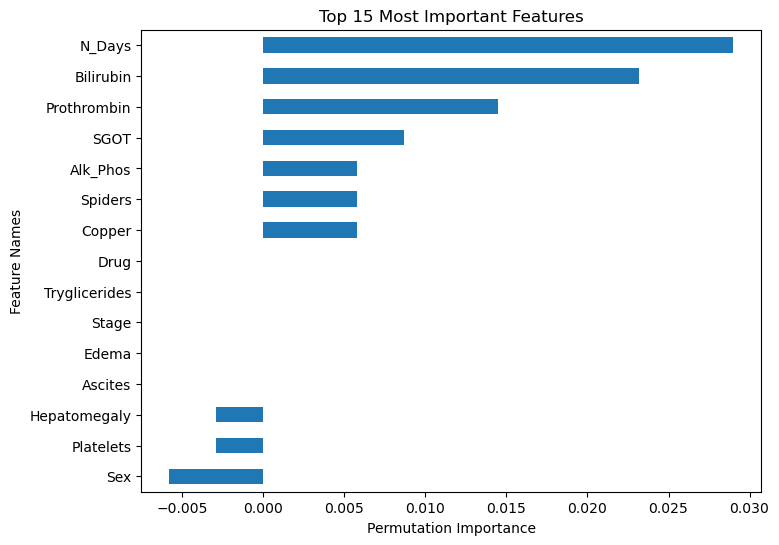

In [34]:
ax = plot_importance(permutation_importances,top_n=15)
ax.set(xlabel='Permutation Importance');


Do these features make sense based on the business case? I would have to refer to the SME about bilirubin. The number of days before an event occurs or check-in could have a strong effect on the status of the patient, as cirrhosis is a progressive disease. I would need to look into why Drug and Stage measures as having zero effect, as that is surprising. 
As knowing whether or not the drug was effective is important, I am going to visualize the relationship between Drug (whether or not D-penicillamine or a placebo were given) and N-Days, and the status of the patient.

## Explanatory Visualizations

The visual below shows the relationship between N_Days, the number of days between registration and a major event such as death, transplantation, or study end, and the patient's status.

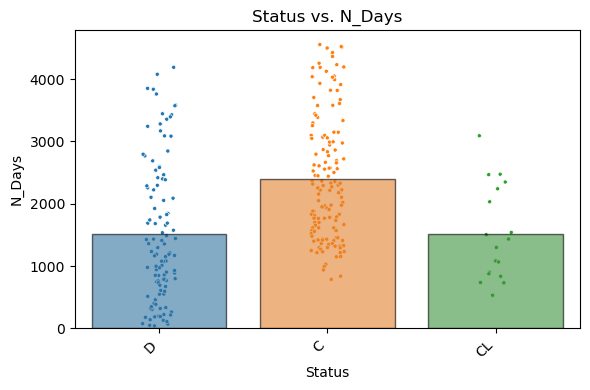

In [35]:
fig, ax = plot_categorical_vs_target(df_new, x = 'Status', y = 'N_Days');

This visual shows that the majority of patients made it to the end of the study at around 2500 days but that a nearly equal amount either died or received a liver transplant in about 1500 days. From an earlier exploratory analysis, it appears that the patients who made it to the end generally were in a lesser stage of cirrhosis. Those who died and received transplants were at more similar stages of the disease.

This visual shows the relationship between whether or not D-penicillamine or a placebo was given and the status of the patient.

<Axes: xlabel='Status', ylabel='Count'>

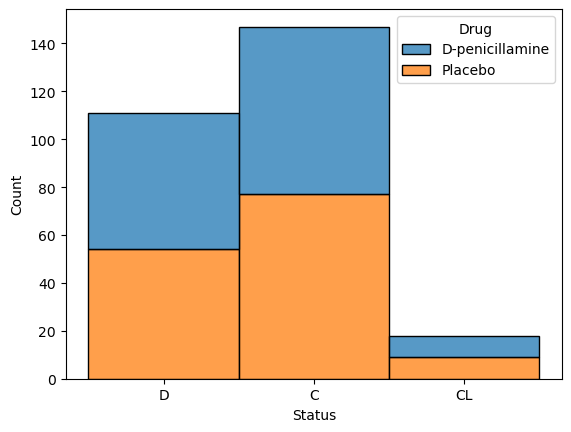

In [36]:
# https://datascience.stackexchange.com/questions/89692/plot-two-categorical-variables

sns.histplot(binwidth=0.5, data=df_new, x="Status", hue="Drug", stat="count", multiple="stack")

There really does not appear to be a correlation between the outcome of a patient and whether or not they were taking D-penicillamine or a placebo.

# Part 2: Feature Selection/Feature Engineering

In [37]:
# New Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

### PCA: 85% Variance

In [38]:
# Instantiate PCA to account for 85% of variance
pca = PCA(n_components=.85)

# Add pca to new pipeline
preprocessor_pca = make_pipeline(preprocessor, pca)

#Fit and transform the data
X_train_pca = preprocessor_pca.fit_transform(X_train)
X_test_pca = preprocessor_pca.transform(X_test)


In [39]:
# Sum of variance explained by 3 principal components
pca.explained_variance_ratio_.sum()



0.879962191663196

### KNN with PCA

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.70      0.88      0.78       108
          CL       0.83      0.28      0.42        18
           D       0.80      0.65      0.72        81

    accuracy                           0.74       207
   macro avg       0.78      0.60      0.64       207
weighted avg       0.75      0.74      0.73       207



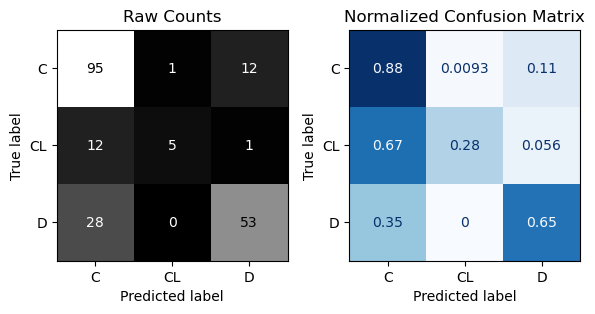


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.74      0.95      0.83        39
           D       0.89      0.57      0.69        30

    accuracy                           0.78        69
   macro avg       0.82      0.76      0.76        69
weighted avg       0.81      0.78      0.77        69



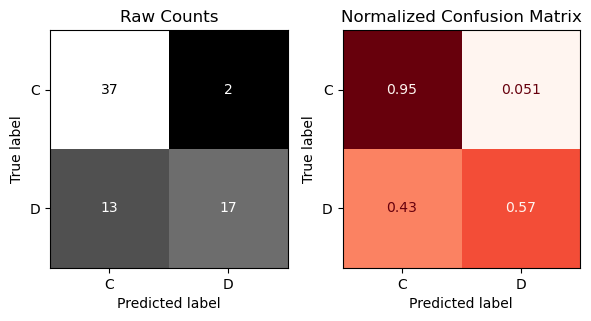

In [40]:
# Instantiate the model
knn_pca = KNeighborsClassifier()

# Fit the model
knn_pca.fit(X_train_pca, y_train)

# Evaluate the model
evaluate_classification(knn_pca, X_train_pca, y_train, 
                 X_test_pca, y_test)

### RF with PCA

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       108
          CL       1.00      1.00      1.00        18
           D       1.00      1.00      1.00        81

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207



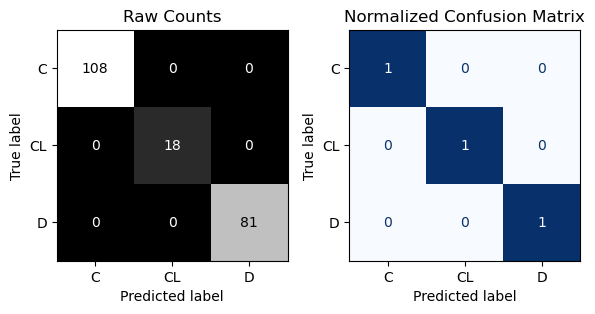


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.85      0.87      0.86        39
           D       0.83      0.80      0.81        30

    accuracy                           0.84        69
   macro avg       0.84      0.84      0.84        69
weighted avg       0.84      0.84      0.84        69



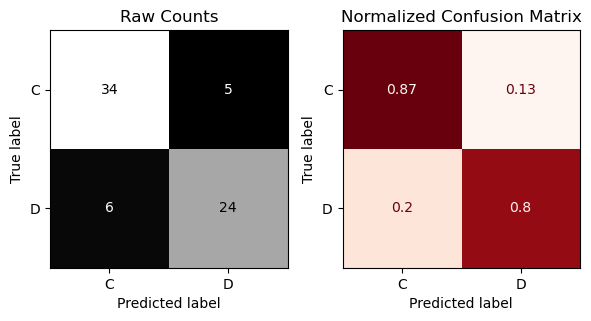

In [41]:
# Instantiate the model
rf_pca = RandomForestClassifier(random_state=42)

# Fit the model
rf_pca.fit(X_train_pca, y_train)

# Evaluate the model
evaluate_classification(rf_pca, X_train_pca, y_train, 
                 X_test_pca, y_test)

### Model Comparison

This model performed similarly to the first random forest model, with 0.84 vs. 0.83 accuracy. This model could likely be improved by adjusting the n_components of the PCA either to a higher variance or a higher number of components. Applying feature engineering methods may also improve accuracy.

Adding SMOTE fitting may also improve the model, as there is a great imbalance among Statuses.

from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()

### Feature Selection: Wrapper

In [42]:
from sklearn.feature_selection import SequentialFeatureSelector

In [43]:
rf = RandomForestClassifier(random_state=42)
preprocessor_wrapper = make_pipeline(preprocessor)

preprocessor_wrapper

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object'))],
                                   verbose_feature_names_out=False))])

In [44]:
# Instantiate the SequentialFeatureSelector
skf_wrapper = SequentialFeatureSelector(rf, n_features_to_select=10,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)

#Fit and transform the data
X_train_wrapper = preprocessor_wrapper.fit_transform(X_train)
X_test_wrapper = preprocessor_wrapper.transform(X_test)

skf_wrapper.fit(X_train_wrapper, y_train)



SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=10, n_jobs=-1)

In [45]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = skf_wrapper.support_
# Only include the features selected
X_train_10 = X_train_wrapper.loc[:,features_to_keep]
X_test_10 = X_test_wrapper.loc[:,features_to_keep]
X_train_10.shape



(207, 10)

# Final Model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       108
          CL       1.00      1.00      1.00        18
           D       1.00      1.00      1.00        81

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207



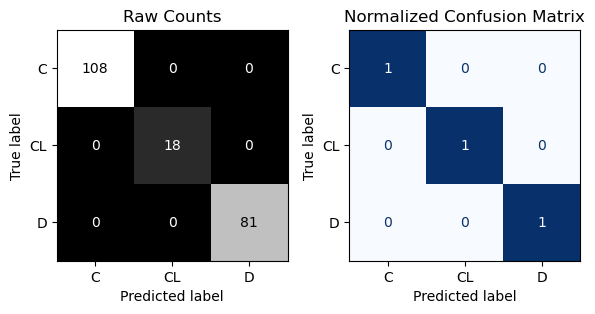


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.83      0.87      0.85        39
           D       0.82      0.77      0.79        30

    accuracy                           0.83        69
   macro avg       0.83      0.82      0.82        69
weighted avg       0.83      0.83      0.83        69



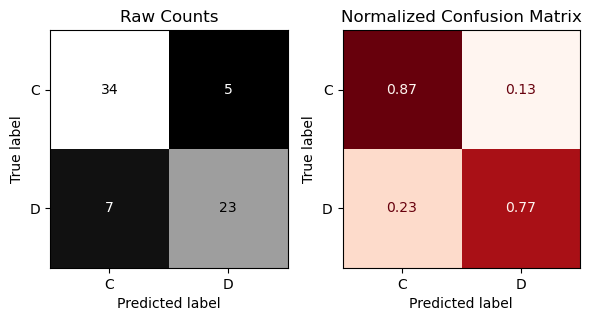

In [46]:
# Fit on 10 selected features
rf.fit(X_train_10, y_train)
# Evaluate with custom function
evaluate_classification(rf, X_train_10, y_train, X_test_10, y_test)

### Top 10 Features

In [47]:
r = permutation_importance(rf, X_test_10, y_test, n_repeats =5, random_state = 42)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [48]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_10.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances


N_Days           0.052174
Bilirubin        0.046377
Prothrombin      0.028986
Copper           0.023188
Age              0.014493
Stage            0.011594
Sex_F            0.008696
Edema_S         -0.002899
Tryglicerides   -0.011594
Cholesterol     -0.028986
Name: permutation importance, dtype: float64

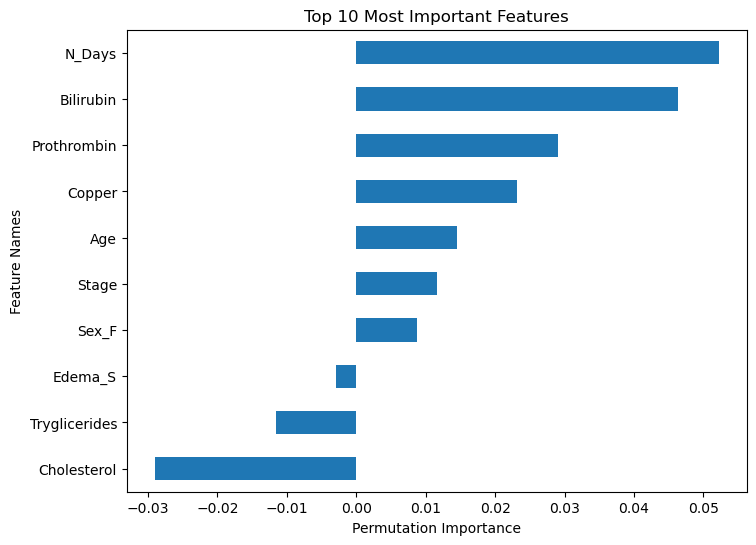

In [49]:
ax = plot_importance(permutation_importances,top_n=10)
ax.set(xlabel='Permutation Importance');


### Comparison to 1st model

There are a few differences in the Top Most Important Features compared to my first analysis. N_Days, Bilirubin, and Prothrombin remained in the Top 3, but Copper, Age, Stage, and Sex all moved up, and Spiders, SGOT, and Alk_Phos moved out of the Top 10. However, one hot encoding broke up Sex into Sex_F and Sex_M and Edema into Edema_S, Edema_Y, and Edema_S, and the analysis was sorted based on the new variables. So, it may be the case that those particular values for those features have a higher importance than the other values.

# Deep Learning Models

## Predicting whether or not a patient will die of Cirrhosis

### Imports and Custom Functions

In [50]:
## Imports
import os

# Import tensorflow
import tensorflow as tf

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
 
#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [51]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



### Check Data

In [52]:
#Starting with the original dataframe to capture Status of 106 patients with missing data
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [54]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [55]:
#Find inconsistant categories of data
#Create index variable that contains all string columns in dataframe
string_cols = df.select_dtypes("object").columns
string_cols

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

In [56]:
#Create loop that shows value counts for each string column in dataframe
for col in string_cols:
  print (f"Value Counts for {col}")
  print(df[col].value_counts())
  print ('\n') #For readability

Value Counts for Status
C     232
D     161
CL     25
Name: Status, dtype: int64


Value Counts for Drug
D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64


Value Counts for Sex
F    374
M     44
Name: Sex, dtype: int64


Value Counts for Ascites
N    288
Y     24
Name: Ascites, dtype: int64


Value Counts for Hepatomegaly
Y    160
N    152
Name: Hepatomegaly, dtype: int64


Value Counts for Spiders
N    222
Y     90
Name: Spiders, dtype: int64


Value Counts for Edema
N    354
S     44
Y     20
Name: Edema, dtype: int64




In [57]:
# Combining C and CL as both categories mean the patient survived
df['Status'] = df['Status'].str.replace('CL','C')
df['Status'].value_counts()

C    257
D    161
Name: Status, dtype: int64

In [58]:
df['Status'].replace(['C','D'],[1,0], inplace = True)
df['Status']

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    1
416    1
417    1
Name: Status, Length: 418, dtype: int64

### Split Data

In [59]:
# Define Target
target = 'Status'

# Define X and y
y = df[target]
X = df.drop(columns = [target, 'ID'])
X.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
132,2796,Placebo,22881,M,N,N,N,N,1.5,331.0,3.95,13.0,577.0,128.65,99.0,165.0,10.1,4.0
60,4256,Placebo,16034,M,N,N,N,N,0.6,216.0,3.94,28.0,601.0,60.45,188.0,211.0,13.0,1.0
198,1592,D-penicillamine,14872,F,N,N,N,N,2.1,392.0,3.43,52.0,1395.0,184.45,194.0,328.0,10.2,3.0
332,1518,NaN,20454,F,NaN,NaN,NaN,N,2.8,NaN,3.92,NaN,NaN,NaN,NaN,NaN,10.6,4.0
63,1487,Placebo,22977,F,N,Y,N,N,2.1,373.0,3.50,52.0,1009.0,150.35,188.0,178.0,11.0,3.0


In [61]:
# Split the X_test_val into test and val data 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)


## Preprocess Data

In [62]:
# lists of columns for transformer
num_cols = X_train.select_dtypes("number").columns
cat_cols = X_train.columns.drop(num_cols)


In [63]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA

# Impute missing values
impute_median = SimpleImputer(strategy = "median")
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)


# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA

# Impute missing values using most_frequent
impute_freq = SimpleImputer(strategy = "most_frequent")
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_freq, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ("categorical", ohe_pipe, cat_cols)

# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
# Fit on training data
col_transformer.fit(X_train)

# Transform the training data
X_train_tf = col_transformer.transform(X_train)
# Transform the testing data
X_test_tf = col_transformer.transform(X_test)
# Transform the validation data
X_val_tf = col_transformer.transform(X_val)
# View the processed training data
X_train_tf.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
132,0.827100,1.094673,-0.358084,-0.126143,1.055965,-1.084819,-0.670351,0.286023,-0.402506,-0.967827,-0.627892,1.114978,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
60,2.200277,-0.648012,-0.570223,-0.690815,1.032169,-0.868242,-0.655754,-1.187780,1.194278,-0.494040,2.368624,-2.262326,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
198,-0.305300,-0.943761,-0.216657,0.173378,-0.181392,-0.521720,-0.172817,1.491861,1.301926,0.711025,-0.524564,-0.010790,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
332,-0.374900,0.476958,-0.051660,-0.234167,0.984579,-0.247391,-0.297505,-0.149419,-0.187210,-0.046003,-0.111251,1.114978,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
63,-0.404056,1.119106,-0.216657,0.080085,-0.014825,-0.521720,-0.407595,0.754960,1.194278,-0.833931,0.302062,-0.010790,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


## Build Neural Network

In [64]:
# define input shape
input_shape = X_train_tf.shape[1]
input_shape


25

In [65]:
# Build binary classification model within function
def build_model():
    # Sequential model
    model = Sequential()

    # First hidden layer
    model.add(Dense(50,
                    input_dim = input_shape, 
                    activation = 'relu')) 

    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))

    ### Metrics are specified during the.compile step
    # Step 2: Compile
    model.compile(loss = 'bce', optimizer = 'adam',
                   metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [66]:
# Call our build function to build model
cirr_model = build_model()

# Get model summary
cirr_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1300      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,351
Trainable params: 1,351
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Intiate Early Stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)



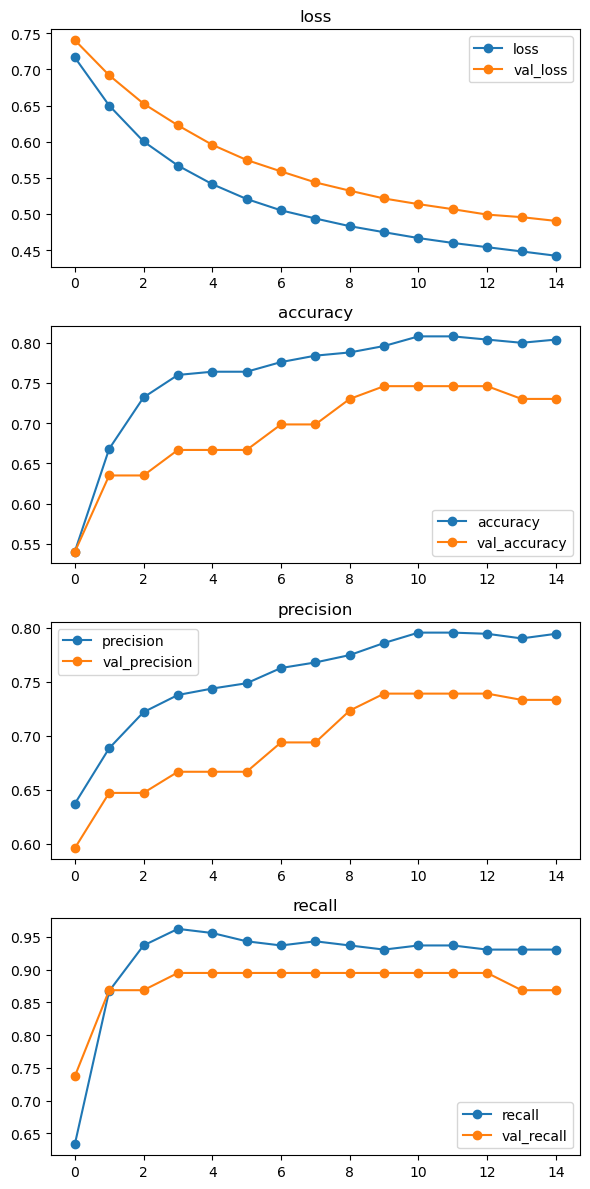

In [68]:
# Step 3: Fit our model
history = cirr_model.fit(X_train_tf, y_train,
                    validation_split=.2, 
                    epochs=50, verbose = 0, callbacks = [early_stop])

plot_history(history);


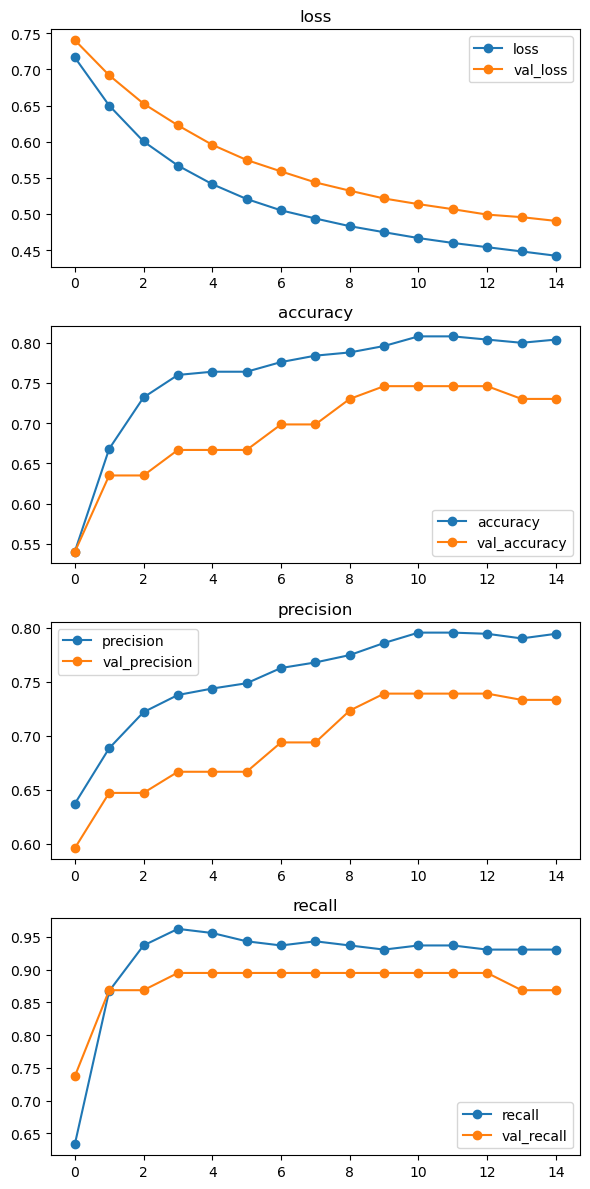

In [69]:
# Call the custom function
plot_history(history);


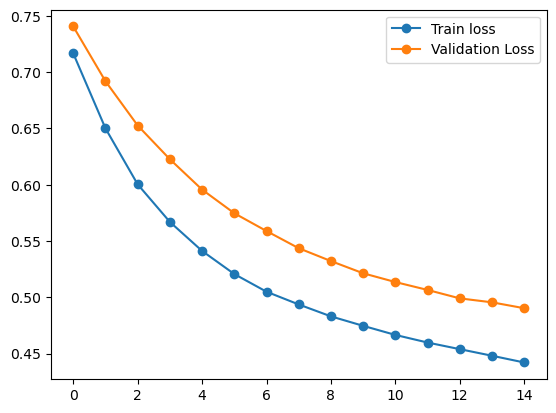

In [70]:
# Visualize the loss
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train loss', marker='o')
ax.plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax.legend();

In [71]:
# make predictions
y_pred_test = cirr_model.predict(X_test_tf)
y_pred_test[:5]



2/2 [==============================] - 0s 2ms/step


array([[0.81410277],
       [0.92915154],
       [0.6072813 ],
       [0.26663473],
       [0.6664291 ]], dtype=float32)

In [72]:
# round the predictions
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]



array([[1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        24
           1       0.76      0.86      0.81        29

    accuracy                           0.77        53
   macro avg       0.78      0.76      0.77        53
weighted avg       0.78      0.77      0.77        53



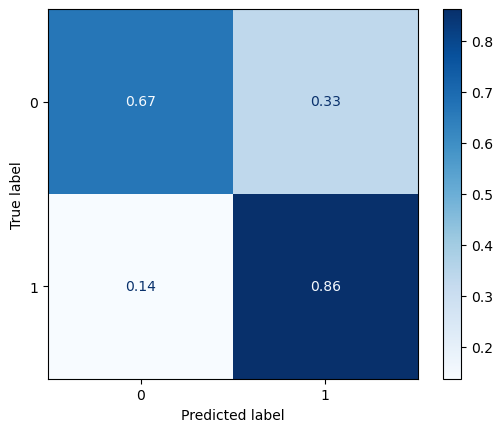

In [73]:
# Evaluate Model
print(classification_report(y_test, y_pred_test))
 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');



## Keras Tuning

In [85]:
# Build binary classification model within function
def build_model(hp):
    # Sequential model
    model = Sequential()

    # First hidden layer
    model.add(Dense(units=hp.Int('units', min_value = 5, max_value = 80, step= 5),
                    input_dim = input_shape, 
                    activation = 'relu')) 

    # Try different dropout rates
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))

    ### Metrics are specified during the.compile step
    # Step 2: Compile
    model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    return model

In [86]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)



In [87]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=100,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='Cirrhosis Prediction')



In [88]:
# Run the tuner
epochs = 50
tuner.search(X_train_tf, y_train,  epochs=epochs,
             validation_data = (X_val_tf, y_val), callbacks = [early_stop])



Trial 254 Complete [00h 00m 02s]
val_accuracy: 0.8461538553237915

Best val_accuracy So Far: 0.9038461446762085
Total elapsed time: 00h 06m 00s
INFO:tensorflow:Oracle triggered exit


In [89]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values



{'units': 60,
 'dropout_value': 0.0,
 'optimizer': 'rmsprop',
 'tuner/epochs': 12,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 3,
 'tuner/round': 1,
 'tuner/trial_id': '0173'}

In [90]:
# Obtain best model
best_model = tuner.get_best_models()[0]
best_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1560      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Evaluate neural network with tuned optimizer, units, and dropout
result = best_model.evaluate(X_test_tf, y_test, return_dict=True)
result



2/2 [==============================] - 0s 8ms/step - loss: 0.4346 - accuracy: 0.8491 - recall: 0.8966 - precision: 0.8387


{'loss': 0.43457111716270447,
 'accuracy': 0.849056601524353,
 'recall': 0.8965517282485962,
 'precision': 0.8387096524238586}

In [84]:
# Inspect results in more detail
tuner.results_summary(5)



Results summary
Results in KerasTuner/Cirrhosis Prediction
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 0001 summary
Hyperparameters:
optimizer: rmsprop
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.807692289352417

Trial 0002 summary
Hyperparameters:
optimizer: adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.75

Trial 0000 summary
Hyperparameters:
optimizer: nadam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6153846383094788
